In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from netCDF4 import Dataset

# Data Processing

## read data

In [1]:
paths = ['/home/disk/eos12/wycheng/data/US/dataset/island_1deg_US.nc',\
        '/home/disk/eos12/wycheng/data/US/dataset/ERA5_2012_cape_cg_1deg3hr_US.nc',\
        '/home/disk/eos12/wycheng/data/US/dataset/ERA5_2013_cape_cg_1deg3hr_US.nc',\
        '/home/disk/eos12/wycheng/data/US/dataset/TRMM_2012_pcp_cg_1deg3hr_US.nc',\
        '/home/disk/eos12/wycheng/data/US/dataset/TRMM_2013_pcp_cg_1deg3hr_US.nc',\
        '/home/disk/eos12/wycheng/data/US/dataset/WWLLN_2012_F_cg_1deg3hr_US.nc',\
        '/home/disk/eos12/wycheng/data/US/dataset/WWLLN_2013_F_cg_1deg3hr_US.nc']

In [3]:
dataset = xr.open_mfdataset(paths)

In [4]:
dataset

<xarray.Dataset>
Dimensions:  (Time: 5848, lat: 40, lon: 75)
Coordinates:
  * Time     (Time) datetime64[ns] 2012-01-01 ... 2013-12-31T21:00:00
  * lat      (lat) float32 20.5 21.5 22.5 23.5 24.5 ... 55.5 56.5 57.5 58.5 59.5
  * lon      (lon) float32 -134.5 -133.5 -132.5 -131.5 ... -62.5 -61.5 -60.5
Data variables:
    F        (Time, lat, lon) float32 dask.array<chunksize=(2928, 40, 75), meta=np.ndarray>
    cape     (Time, lat, lon) float32 dask.array<chunksize=(2928, 40, 75), meta=np.ndarray>
    island   (lat, lon) int32 dask.array<chunksize=(40, 75), meta=np.ndarray>
    pcp      (Time, lat, lon) float32 dask.array<chunksize=(2928, 40, 75), meta=np.ndarray>
Attributes:
    creation_date:  Wed Jan 20 16:09:48 PST 2021
    Conventions:    None
    source_file:    
    title:

In [13]:
dataframe = dataset.where( (dataset.island == 1) & (dataset.pcp<0.833) ).to_dataframe().dropna(axis=0)

In [18]:
dataframe = dataframe.assign(isT=np.where( (dataframe.F>=1),1,0) )
dataframe = dataframe.assign(isDT=np.where( (dataframe.pcp<0.833) & (dataframe.F>=1),1,0) )

## check data

In [19]:
dataframe

F        cape  island       pcp  isT  \
Time                lat  lon                                                
2012-01-01 00:00:00 20.5 -105.5    0.0   26.936972     1.0  0.045319    0   
                         -104.5    0.0  193.959839     1.0  0.619060    0   
                         -102.5    4.0    0.000000     1.0  0.698779    1   
                         -101.5  511.0   17.618164     1.0  0.047142    1   
                         -100.5  806.0   28.618326     1.0  0.000000    1   
...                                ...         ...     ...       ...  ...   
2013-12-31 21:00:00 49.5 -71.5     0.0    0.001953     1.0  0.000000    0   
                         -70.5     0.0    0.001953     1.0  0.000000    0   
                         -69.5     0.0    0.030273     1.0  0.000000    0   
                         -68.5     0.0    0.497640     1.0  0.000000    0   
                         -67.5     0.0    3.034139     1.0  0.000000    0   

                                 isDT  
Time                lat  lon           
2012-01-01 00:00:00 20.5 -105.5     0  
                         -104.5     0  
                         -102.5     1  
                         -101.5     1  
                         -100.5     1  
...                               ...  
2013-12-31 21:00:00 49.5 -71.5      0  
                         -70.5      0  
                         -69.5      0  
                         -68.5      0  
                         -67.5      0  

[6366461 rows x 6 columns]

In [21]:
dataframe.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6366461 entries, (Timestamp('2012-01-01 00:00:00'), 20.5, -105.5) to (Timestamp('2013-12-31 21:00:00'), 49.5, -67.5)
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   F       float32
 1   cape    float32
 2   island  float64
 3   pcp     float32
 4   isT     int64  
 5   isDT    int64  
dtypes: float32(3), float64(1), int64(2)
memory usage: 243.0 MB


## formatting input (training/test) data

In [22]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

In [24]:
feature_name  = ['cape','pcp']
output_name   = ['isDT']

X = dataframe[feature_name]
y = dataframe[output_name]

In [25]:
print(y.where(y.isDT==0).count())
print(y.where(y.isDT>=1).count())

isDT    6002568
dtype: int64
isDT    363893
dtype: int64


In [26]:
undersample = RandomUnderSampler(sampling_strategy=0.25)

In [27]:
X_train_raw, X_test, y_train_raw, y_test = train_test_split(X, y, test_size=0.33, random_state=None)
X_train, y_train = undersample.fit_resample(X_train_raw, y_train_raw)

In [28]:
print(X_train.info())
print(y_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216695 entries, 0 to 1216694
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   cape    1216695 non-null  float32
 1   pcp     1216695 non-null  float32
dtypes: float32(2)
memory usage: 9.3 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216695 entries, 0 to 1216694
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   isDT    1216695 non-null  int64
dtypes: int64(1)
memory usage: 9.3 MB
None


# ML

## R14

In [29]:
import scipy as sp
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.preprocessing import normalize

In [30]:
class R14:
    
    def fit(CAPE,pcp,y):

        thrs = sp.optimize.fminbound(lambda x: -f1_score(y, ((CAPE*pcp > x) * 1.0).astype(int)), 0, 4000)
        fval = f1_score(y, ((CAPE*pcp >= thrs) * 1.0).astype(int))
        
        return thrs, fval
    
    def predict(CAPE,pcp,thrs):
        
        y_predict = ((CAPE*pcp >= thrs) * 1.0).astype(int)
        y_predict_proba = CAPE*pcp
        
        return y_predict, y_predict_proba/np.max(y_predict_proba)

In [31]:
[r14_thrs,fval] = R14.fit(X_train['cape'],X_train['pcp'],y_train)

In [32]:
print(r14_thrs, fval)

0.21579020919417435 0.5653593829544036


In [33]:
r14_thrs_linspace = np.linspace(np.max(r14_thrs-10,0),r14_thrs+10,num=20)
fval_linspace     = np.zeros(np.shape(r14_thrs_linspace))

In [34]:
i = 0
for r14_thrs_i in r14_thrs_linspace:
    fval_linspace[i] = f1_score(y_train['isDT'], ((X_train['cape']*X_train['pcp'] >= r14_thrs_i) * 1.0).astype(int))
    i = i+1

Text(0, 0.5, 'F1 score')

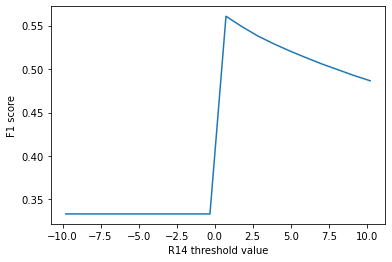

In [35]:
plt.plot(r14_thrs_linspace,fval_linspace)
plt.xlabel('R14 threshold value')
plt.ylabel('F1 score')

In [36]:
y_predict_r14, y_predict_prob_r14 = R14.predict(X_test['cape'],X_test['pcp'],r14_thrs)

## random forest

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
rfclf = RandomForestClassifier(n_estimators=10, max_depth=4, min_samples_split=10, random_state=0)

In [39]:
rfclf.fit(X_train[feature_name], y_train[output_name])

<ipython-input-39-f484fe52f948>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfclf.fit(X_train[feature_name], y_train[output_name])


RandomForestClassifier(max_depth=4, min_samples_split=10, n_estimators=10,
                       random_state=0)

In [40]:
y_predict_rfclf = rfclf.predict(X_test[feature_name])

## Model Evaluation

In [41]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import plot_roc_curve

In [42]:
pd.DataFrame(
    [[precision_score(y_test['isDT'], y_predict_r14),\
      recall_score(y_test['isDT'], y_predict_r14),\
      f1_score(y_test['isDT'], y_predict_r14)],\
     [precision_score(y_test['isDT'], y_predict_rfclf),\
      recall_score(y_test['isDT'], y_predict_rfclf),\
      f1_score(y_test['isDT'], y_predict_rfclf)]],
    columns=['Precision Score', 'Recall Score', 'F1 Score'],
    index=['R14', 'RFC']
).style.apply(lambda x: ["background: yellow" if v == x.max() else "" for v in x], axis = 0)

,Precision Score,Recall Score,F1 Score
R14,0.343144,0.486462,0.402424
RFC,0.453389,0.431027,0.441925


In [43]:
auc_rfclf = metrics.roc_auc_score(y_test, rfclf.predict_proba(X_test)[:,1])
auc_r14   = metrics.roc_auc_score(y_test, y_predict_prob_r14)
print(auc_rfclf, auc_r14)

0.8805094511509166 0.7257592746019482


In [44]:
xthrs = np.linspace(0,4000,20)
fpr = []
tpr = []
for i in range(np.size(xthrs)):
    yp, fv = R14.predict(X_test['cape'],X_test['pcp'],xthrs[i])
    tn, fp, fn, tp = confusion_matrix(y_test['isDT'], yp).ravel()
    fpr.append( (fp/(fp+tn)) ) 
    tpr.append( (tp/(tp+fn)) )

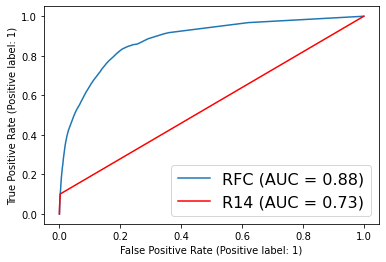

In [45]:
plot_roc_curve(rfclf, X_test, y_test, label='RFC (AUC = %0.2f)'%(auc_rfclf) ) 
plt.plot(fpr, tpr, 'r-',label='R14 (AUC = %0.2f)'%(auc_r14))
plt.legend(fontsize=16)
plt.show()  

In [46]:
pd.DataFrame(
    confusion_matrix(y_test['isDT'], y_predict_rfclf),
    columns=['Predicted No DT', 'Predicted DT'],
    index=['True No DT', 'True DT']
)

,Predicted No DT,Predicted DT
True No DT,1917733,62646
True DT,68592,51962


In [47]:
pd.DataFrame(
    confusion_matrix(y_test['isDT'], y_predict_r14),
    columns=['Predicted No DT', 'Predicted DT'],
    index=['True No DT', 'True DT']
)

,Predicted No DT,Predicted DT
True No DT,1868119,112260
True DT,61909,58645


## Plots

In [48]:
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker

In [49]:
idx = y_test.index
y_predict_r14_df   = pd.DataFrame(y_predict_r14, index=idx, columns=['y_predict_r14'])
y_predict_rfclf_df = pd.DataFrame(y_predict_rfclf, index=idx, columns=['y_predict_rfclf'])

In [50]:
def plot_map(figsize,data,cmap,vmin=None,vmax=None,title=None,unit=None):
    
    fig   = plt.figure(figsize=figsize)

    pcm = data.plot.pcolormesh("lon","lat",
        subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="white"),
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        vmin=vmin,vmax=vmax,
        add_colorbar = False,
    )
    pcm.axes.set_extent([-135, -60, 20, 60], ccrs.PlateCarree())
    gl = pcm.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlocator = mticker.FixedLocator([-130, -120, -110, -100, -90, -80, -70, -60])
    gl.ylocator = mticker.FixedLocator([20, 30, 40, 50, 60])
    gl.xlabels_top   = False
    gl.ylabels_right = False
    pcm.axes.coastlines()
    plt.title(title)

    divider = make_axes_locatable(pcm.axes)
    cax     = divider.append_axes("right", size="2%", pad=1, axes_class=plt.Axes)
    cbar    = plt.colorbar(pcm, cax=cax,extend='max')
    plt.text(vmin,vmax*1.08,unit)

/home/disk/p/wycheng/anaconda3/envs/incubator2021/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/disk/p/wycheng/anaconda3/envs/incubator2021/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


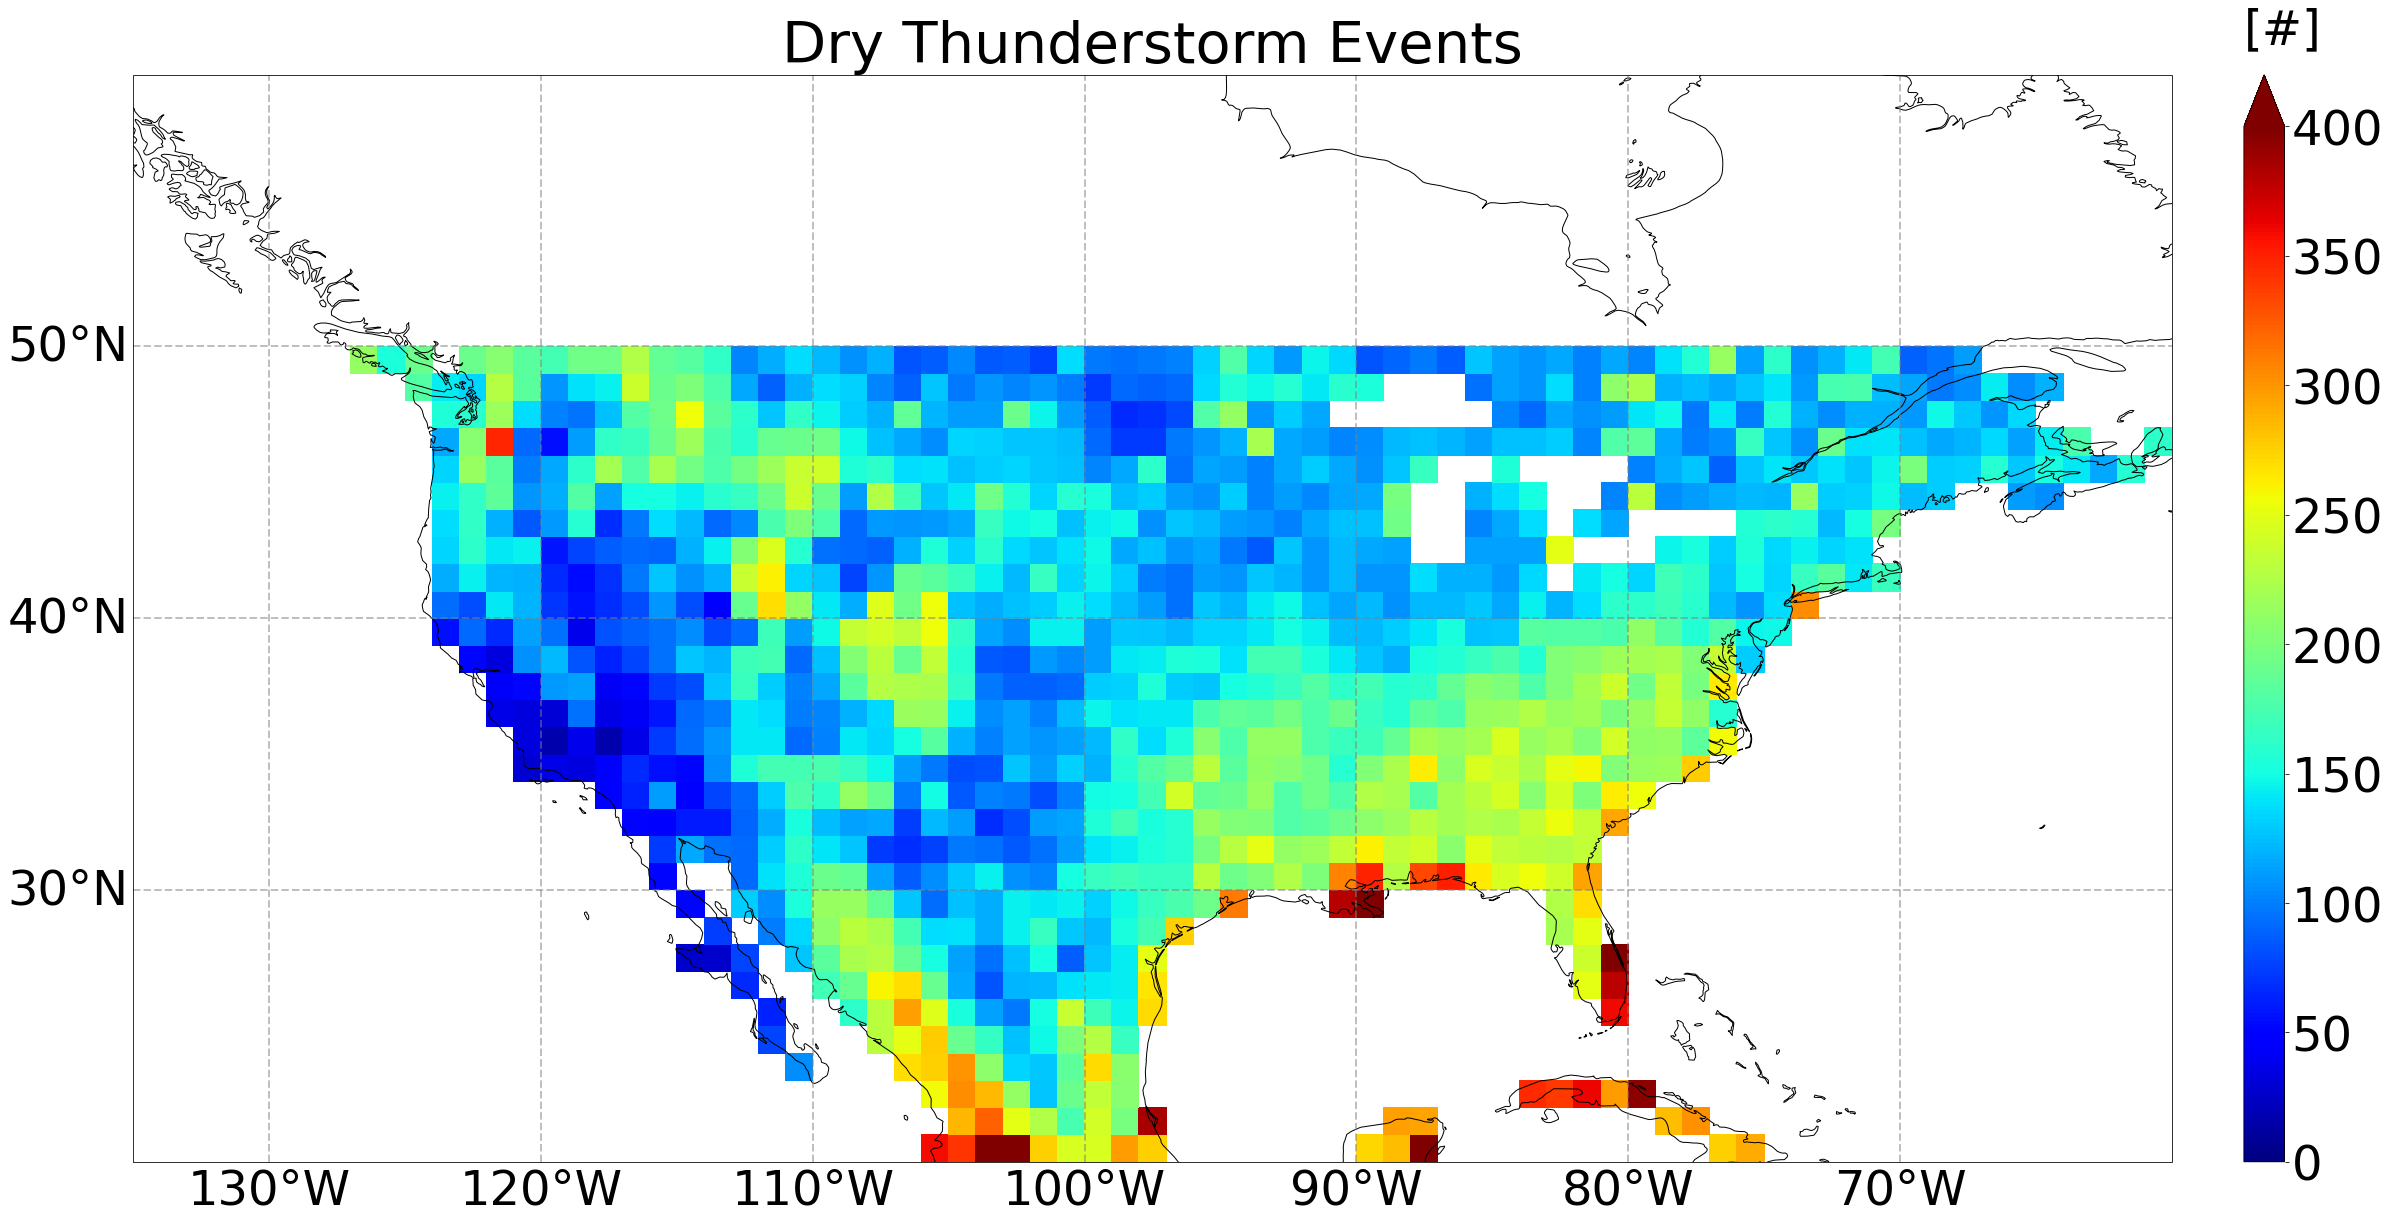

In [52]:
plt.rcParams.update({'font.size': 48})
figsize = (40,20)
data  = y_predict_r14_df['y_predict_r14'].groupby(['lat','lon']).sum().to_xarray().where(dataset.island==1)
cmap  = plt.get_cmap('jet')
vmin  = 0
vmax  = 400
title = 'Dry Thunderstorm Events'
unit  = '[#]'

plot_map(figsize,data=data,cmap=cmap,vmin=vmin,vmax=vmax,title=title,unit=unit)

/home/disk/p/wycheng/anaconda3/envs/incubator2021/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/disk/p/wycheng/anaconda3/envs/incubator2021/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


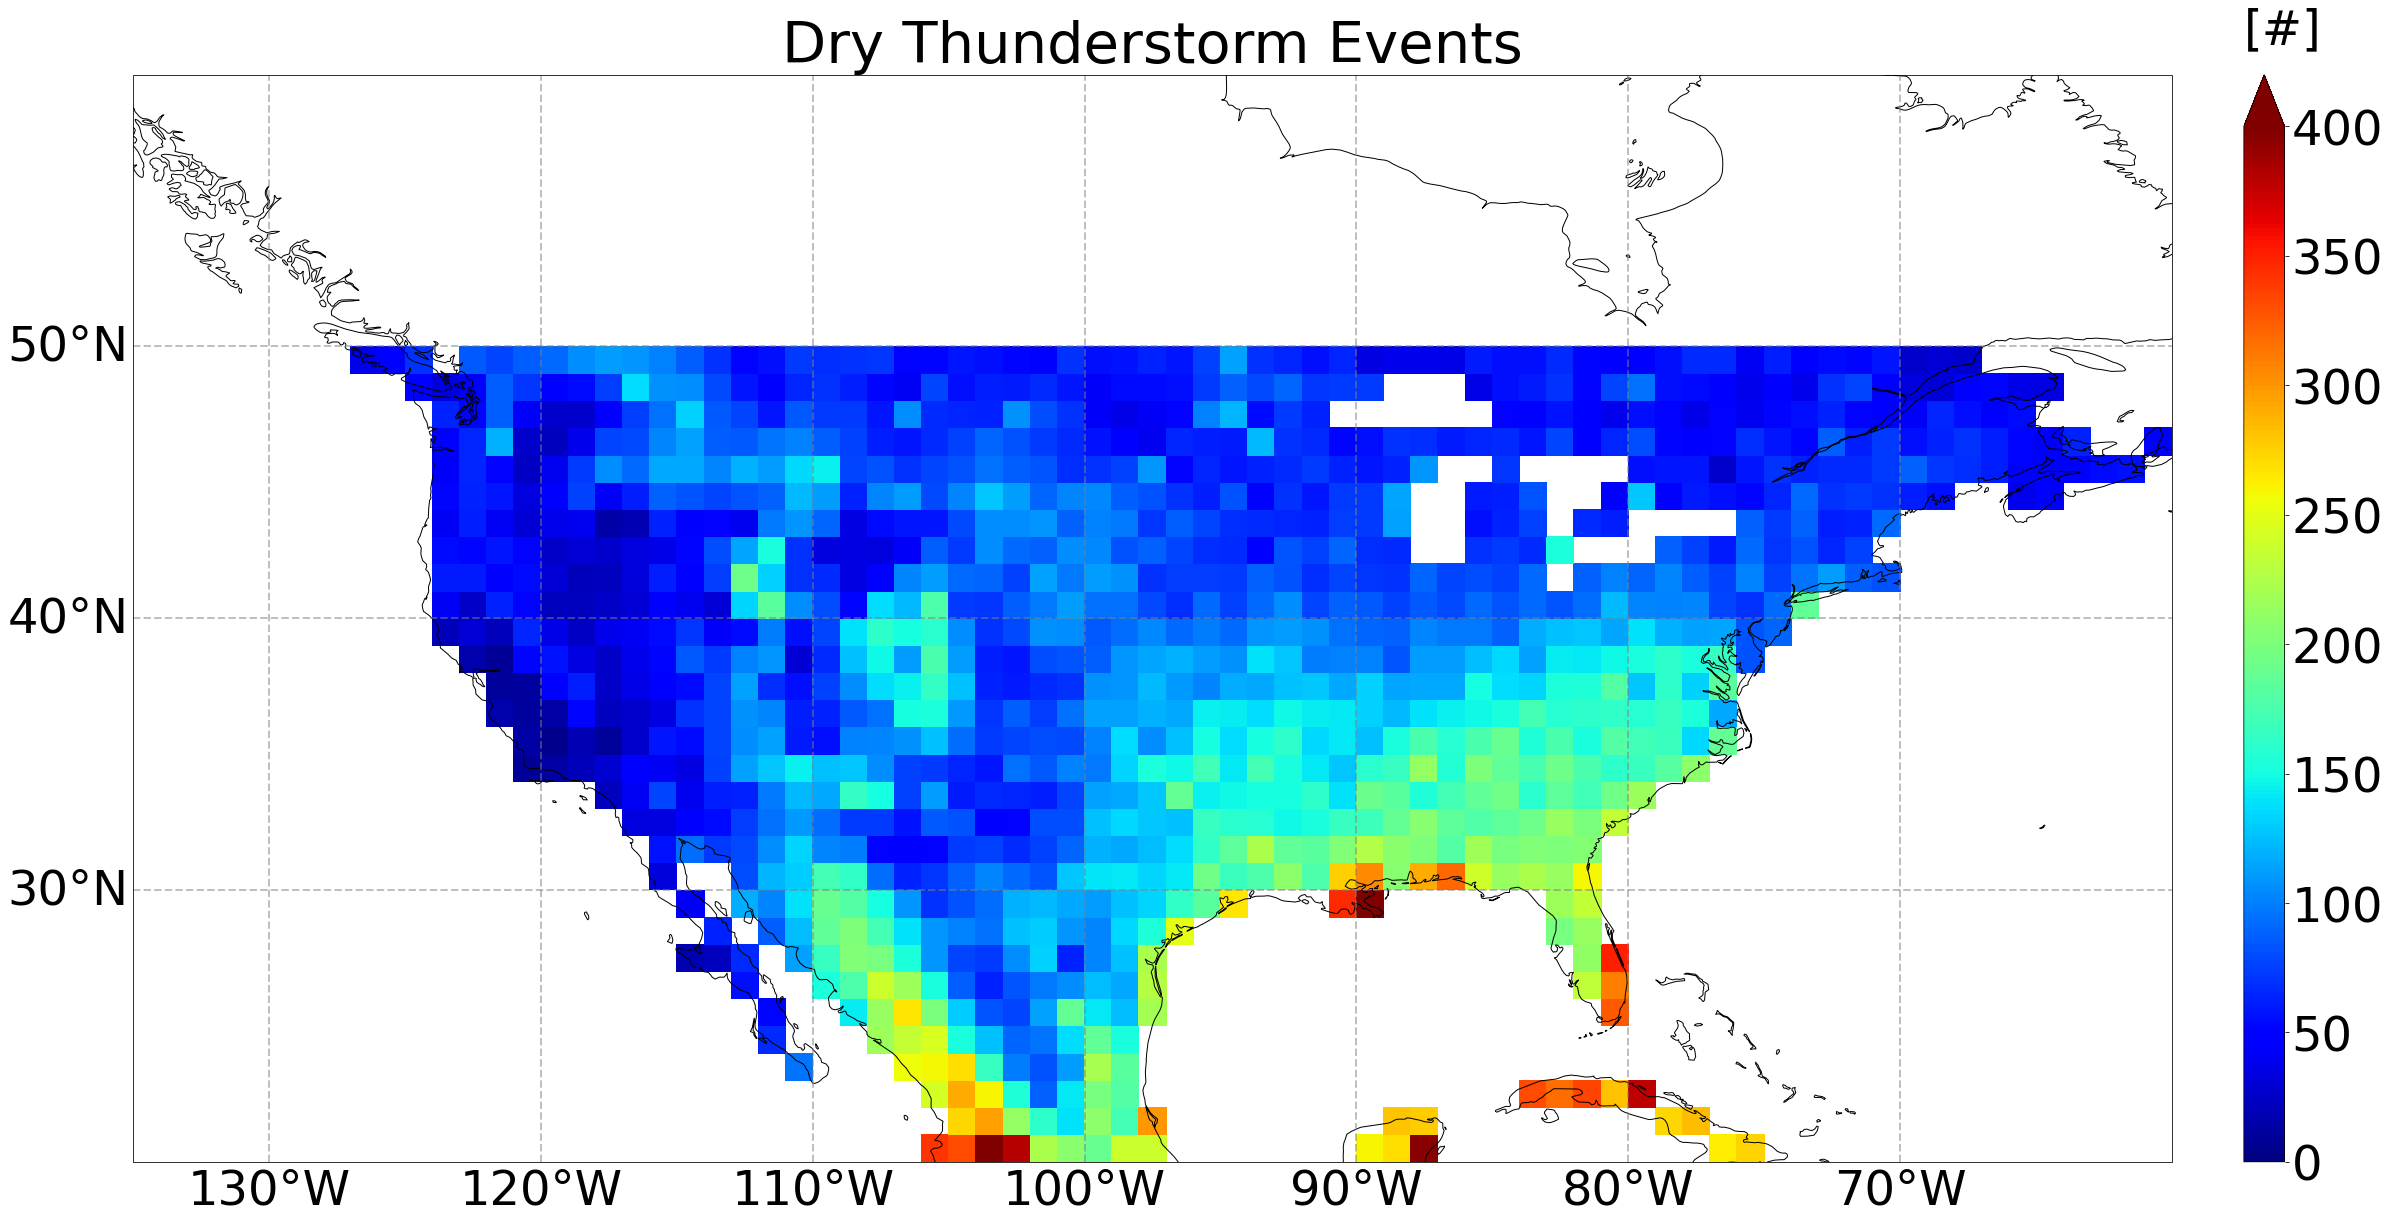

In [53]:
plt.rcParams.update({'font.size': 48})
figsize = (40,20)
data  = y_predict_rfclf_df['y_predict_rfclf'].groupby(['lat','lon']).sum().to_xarray().where(dataset.island==1)
cmap  = plt.get_cmap('jet')
vmin  = 0
vmax  = 400
title = 'Dry Thunderstorm Events'
unit  = '[#]'

plot_map(figsize,data=data,cmap=cmap,vmin=vmin,vmax=vmax,title=title,unit=unit)

/home/disk/p/wycheng/anaconda3/envs/incubator2021/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/disk/p/wycheng/anaconda3/envs/incubator2021/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


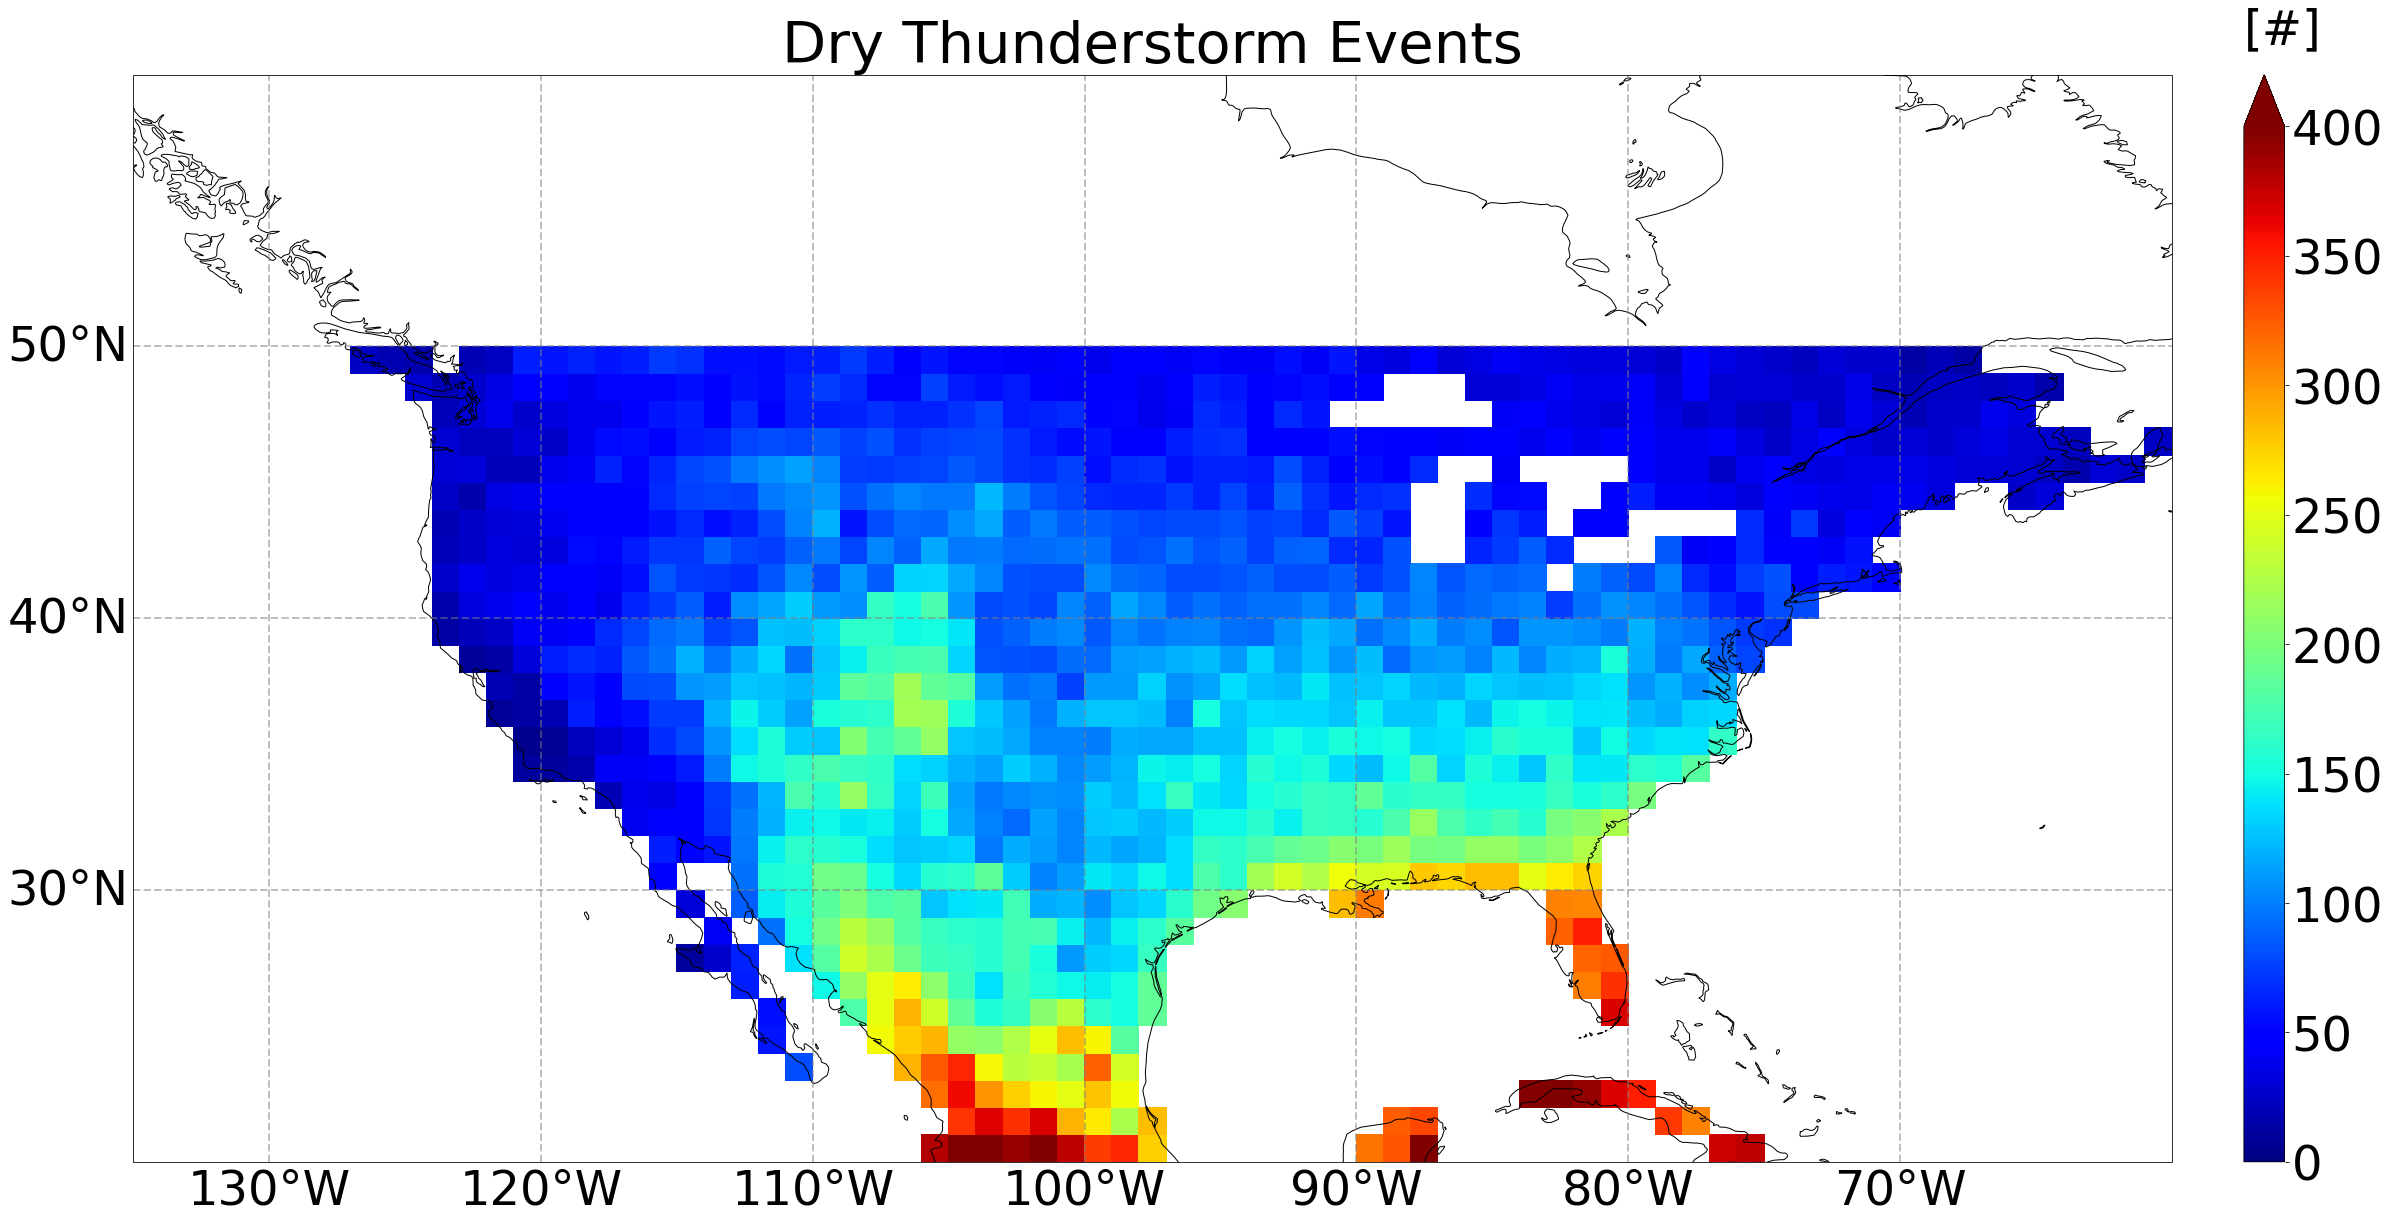

In [54]:
plt.rcParams.update({'font.size': 48})
figsize = (40,20)
data  = y_test['isDT'].groupby(['lat','lon']).sum().to_xarray().where(dataset.island==1)
cmap  = plt.get_cmap('jet')
vmin  = 0
vmax  = 400
title = 'Dry Thunderstorm Events'
unit  = '[#]'

plot_map(figsize,data=data,cmap=cmap,vmin=vmin,vmax=vmax,title=title,unit=unit)